# Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pyproj import Transformer
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Constants
WINDOW_SIZE = 8          # Past 8 steps = 24 hours (3h per step)
HORIZON = 1              # Predict next 1 step = 3 hours ahead
MIN_LENGTH = 18          # Minimum storm track length
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 15
K_FOLDS = 5              # Number of folds for cross-validation
N_ITER_SEARCH = 5        # Number of iterations for random search

# Feature dimensions
OUTPUT_FEATURES = 2      # [x_km, y_km]

# Physics constants
EARTH_OMEGA = 7.2921e-5  # Earth's rotation rate (rad/s)

In [4]:
# GPU configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU Available: {physical_devices[0].name}")
    tf.config.experimental.set_memory_growth(
        physical_devices[0],
        True
    )
else:
    print("Running on CPU")

print(f"TensorFlow version: {tf.__version__}")

GPU Available: /physical_device:GPU:0
TensorFlow version: 2.18.0


# Utility Functions

In [5]:
# Projection transformers for coordinate conversion
proj_transformer = Transformer.from_crs(
    "EPSG:4326",
    "+proj=lcc +lat_1=30 +lat_2=60 +lat_0=40 +lon_0=-50 +units=km",
    always_xy=True
)
inverse_transformer = Transformer.from_crs(
    "+proj=lcc +lat_1=30 +lat_2=60 +lat_0=40 +lon_0=-50 +units=km",
    "EPSG:4326",
    always_xy=True
)

In [6]:
def convert_positions_to_km(positions_deg):
    """Convert array of (lon, lat) positions from degrees to km"""
    positions_km = []
    for lon, lat in positions_deg:
        x_km, y_km = proj_transformer.transform(lon, lat)
        positions_km.append([x_km, y_km])
    return np.array(positions_km)

In [7]:
def convert_positions_to_deg(positions_km):
    """Convert array of (x, y) positions from km to degrees"""
    positions_deg = []
    for x, y in positions_km:
        lon, lat = inverse_transformer.transform(x, y)
        positions_deg.append([lon, lat])
    return np.array(positions_deg)

In [8]:
def haversine(
    lat1,
    lon1,
    lat2,
    lon2,
    R=6371.0
):
    """Calculate great circle distance between two points"""
    phi1, lambda1, phi2, lambda2 = map(
        np.radians,
        (lat1, lon1, lat2, lon2)
    )
    dphi = phi2 - phi1
    dlambda = lambda2 - lambda1
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Data Loading

In [9]:
# Dataset URL
URL = (
    "https://www.ncei.noaa.gov/data/"
    "international-best-track-archive-for-climate-stewardship-ibtracs/"
    "v04r00/access/csv/ibtracs.NA.list.v04r00.csv"
)

In [10]:
class IBTrACSDataLoader:
    """Data loader for IBTrACS storm data"""

    def __init__(self, url):
        self.url = url
        self.df = None

    def load_data(self):
        """Load raw storm data"""
        # Load data
        self.df = pd.read_csv(
            self.url,
            low_memory=False
        )
        print(f"Loaded {len(self.df):,} records")

        # Remove units row
        self.df = self.df[1:].reset_index(drop=True)

        return self.df

In [11]:
# Load the raw data
loader = IBTrACSDataLoader(URL)
df_raw = loader.load_data()

Loaded 126,971 records


In [12]:
# View all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Select columns to view
df_view = df_raw[[
    'SID',
    'NAME',
    'SEASON',
    'ISO_TIME',
    'LAT',
    'LON',
    'STORM_SPEED',
    'STORM_DIR',
    'DIST2LAND',
    'LANDFALL',
    'TRACK_TYPE',
    'NATURE',
    'NUMBER'
]]

# Sort by SID and ISO_TIME
df_view.sort_values(['SID', 'ISO_TIME'], inplace=True)

In [13]:
# Get 5 random storms
np.random.seed(42)
random_storms = df_view['SID'].unique()
selected_storms = np.random.choice(random_storms, size=5, replace=False)

# Get all data for these 5 storms
df_view_5 = df_view[df_view['SID'].isin(selected_storms)]

# Sample 5 rows from each of the 5 storms
df_view_5_sampled = df_view[df_view['SID'].isin(selected_storms)].groupby('SID').apply(
    lambda x: x.sample(min(5, len(x)))
).reset_index(drop=True)

print("All data for 5 random storms:")
display(df_view_5)  # All rows from 5 random storms
print("\n5 rows of data for 5 random storms:")
display(df_view_5_sampled)  # Up to 5 rows from each of the 5 random storms

All data for 5 random storms:


,SID,NAME,SEASON,ISO_TIME,LAT,LON,STORM_SPEED,STORM_DIR,DIST2LAND,LANDFALL,TRACK_TYPE,NATURE,NUMBER
34817,1896260N16306,NOT_NAMED,1896,1896-09-16 00:00:00,15.5000,-54.5000,9,291,885,858,main,TS,34
34818,1896260N16306,NOT_NAMED,1896,1896-09-16 03:00:00,15.6502,-54.9124,8,291,865,840,main,TS,34
34819,1896260N16306,NOT_NAMED,1896,1896-09-16 06:00:00,15.8000,-55.3000,8,293,840,824,main,TS,34
34820,1896260N16306,NOT_NAMED,1896,1896-09-16 09:00:00,15.9499,-55.6501,7,294,817,810,main,TS,34
34821,1896260N16306,NOT_NAMED,1896,1896-09-16 12:00:00,16.1000,-56.0000,8,293,811,791,main,TS,34
34822,1896260N16306,NOT_NAMED,1896,1896-09-16 15:00:00,16.2500,-56.4000,8,291,800,783,main,TS,34
34823,1896260N16306,NOT_NAMED,1896,1896-09-16 18:00:00,16.4000,-56.8000,8,293,783,774,main,TS,34
34824,1896260N16306,NOT_NAMED,1896,1896-09-16 21:00:00,16.5499,-57.1501,7,294,768,766,main,TS,34
34825,1896260N16306,NOT_NAMED,1896,1896-09-17 00:00:00,16.7000,-57.5000,8,293,770,760,main,TS,34
34826,1896260N16306,NOT_NAMED,1896,1896-09-17 03:00:00,16.8500,-57.9000,8,291,770,761,main,TS,34



5 rows of data for 5 random storms:


,SID,NAME,SEASON,ISO_TIME,LAT,LON,STORM_SPEED,STORM_DIR,DIST2LAND,LANDFALL,TRACK_TYPE,NATURE,NUMBER
0,1896260N16306,NOT_NAMED,1896,1896-09-19 00:00:00,18.8667,-61.5667,11,291,425,374,main,TS,34
1,1896260N16306,NOT_NAMED,1896,1896-09-23 06:00:00,31.2667,-72.4333,22,44,537,535,main,TS,34
2,1896260N16306,NOT_NAMED,1896,1896-09-17 09:00:00,17.1499,-58.6501,7,294,741,706,main,TS,34
3,1896260N16306,NOT_NAMED,1896,1896-09-21 18:00:00,24.7667,-71.7333,11,313,423,420,main,TS,34
4,1896260N16306,NOT_NAMED,1896,1896-09-27 09:00:00,55.0632,-34.1038,24,51,767,767,main,TS,34
5,1911299N23285,NOT_NAMED,1911,1911-10-29 12:00:00,20.5000,-86.5000,2,19,53,47,main,TS,68
6,1911299N23285,NOT_NAMED,1911,1911-10-27 21:00:00,21.5424,-85.0799,6,237,45,45,main,TS,68
7,1911299N23285,NOT_NAMED,1911,1911-10-29 18:00:00,20.8000,-86.4000,4,16,45,33,main,TS,68
8,1911299N23285,NOT_NAMED,1911,1911-10-28 12:00:00,21.0000,-86.0000,3,229,73,63,main,TS,68
9,1911299N23285,NOT_NAMED,1911,1911-10-26 03:00:00,22.4981,-76.2476,14,270,128,90,main,TS,68


In [14]:
# from google.colab import files

# # Save the dataframe to a CSV file
# df_view.to_csv('ibtracs_storm_data.csv', index=False)

# # Download the file
# files.download('ibtracs_storm_data.csv')

# Data Preprocessing

In [15]:
def clean_storm_data(df):
    """Clean and filter storm data"""
    # Convert columns to numeric
    numeric_cols = ['LAT', 'LON', 'SEASON', 'STORM_SPEED', 'STORM_DIR']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(
                df[col],
                errors='coerce'
            )

    # Clean coordinates
    df = df.dropna(subset=['LAT', 'LON'])
    df = df[
        (df['LAT'].abs() <= 90) &
        (df['LON'].abs() <= 180)
    ]

    # Parse dates
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
    df['YEAR'] = df['ISO_TIME'].dt.year

    # Filter pre-1900 storms
    df = df[df['YEAR'] >= 1900].copy()

    return df

In [16]:
# Clean the data
print("Cleaning storm data...")
df = clean_storm_data(df_raw)

Cleaning storm data...


In [17]:
def filter_storms_by_length(
    df,
    min_length
):
    """Filter storms by minimum track length"""
    counts = df['SID'].value_counts()
    valid_sids = counts[counts >= min_length].index
    df_filtered = df[df['SID'].isin(valid_sids)].copy()

    print(f"Filtered to {len(valid_sids)} storms with >= {min_length} points")
    return df_filtered

In [18]:
# Filter by minimum length
df = filter_storms_by_length(df, MIN_LENGTH)

Filtered to 1464 storms with >= 18 points


In [19]:
def add_coordinate_conversions(df):
    """Add km coordinates to dataframe"""
    # Rename columns
    df.rename(
        columns={'LON': 'x', 'LAT': 'y'},
        inplace=True
    )

    # Convert positions to km
    print("Converting positions to km...")
    df['x_km'] = 0.0
    df['y_km'] = 0.0

    for sid in df['SID'].unique():
        mask = df['SID'] == sid
        positions_deg = df.loc[mask, ['x', 'y']].values
        positions_km = convert_positions_to_km(positions_deg)
        df.loc[mask, 'x_km'] = positions_km[:, 0]
        df.loc[mask, 'y_km'] = positions_km[:, 1]

    # Sort data
    df.sort_values(
        ['SID', 'ISO_TIME'],
        inplace=True
    )

    return df

In [20]:
# Add coordinate conversions
df = add_coordinate_conversions(df)

Converting positions to km...


In [21]:
def extract_storm_metadata(df):
    """Extract metadata about storms"""
    metadata = {
        'year': df.groupby('SID')['YEAR'].first().astype(int).to_dict(),
        'track_length': df.groupby('SID').size().to_dict(),
        'start_time': df.groupby('SID')['ISO_TIME'].first().to_dict(),
        'end_time': df.groupby('SID')['ISO_TIME'].last().to_dict()
    }
    return metadata

In [22]:
# Extract metadata
storm_metadata = extract_storm_metadata(df)
print(f"After preprocessing: {len(df):,} records")
print(f"Number of valid storms: {df['SID'].nunique()}")

After preprocessing: 87,013 records
Number of valid storms: 1464


In [23]:
# Determine test years
years = sorted(storm_metadata['year'].values())
TEST_YEARS = sorted(list(set(years[-50:])))[-2:]
VAL_YEARS = 3

print(f"Test years: {TEST_YEARS}")
print(f"Validation years: {TEST_YEARS[0]-VAL_YEARS} to {TEST_YEARS[0]-1}")

Test years: [2022, 2023]
Validation years: 2019 to 2021


In [24]:
def calculate_velocities(
    positions,
    dt=3.0
):
    """Calculate velocity from positions"""
    if len(positions) < 2:
        return np.zeros_like(positions)

    velocities = np.zeros((len(positions), 2))
    velocities[1:] = (positions[1:] - positions[:-1]) / dt
    velocities[0] = velocities[1]  # Duplicate first velocity

    return velocities

In [25]:
def calculate_accelerations(
    velocities,
    dt=3.0
):
    """Calculate acceleration from velocities"""
    if len(velocities) < 2:
        return np.zeros_like(velocities)

    accelerations = np.zeros((len(velocities), 2))
    accelerations[1:] = (velocities[1:] - velocities[:-1]) / dt
    accelerations[0] = accelerations[1]  # Duplicate first acceleration

    return accelerations

In [26]:
def calculate_track_curvature(
    positions,
    velocities
):
    """Calculate track curvature at each point"""
    if len(positions) < 3:
        return np.zeros(len(positions))

    # Calculate speed
    speed = np.sqrt(velocities[:, 0]**2 + velocities[:, 1]**2)
    speed[speed < 1e-6] = 1e-6  # Avoid division by zero

    # Calculate change in heading
    heading = np.arctan2(velocities[:, 1], velocities[:, 0])
    heading_change = np.zeros(len(heading))
    heading_change[1:] = np.diff(heading)

    # Normalize to [-pi, pi]
    heading_change = np.arctan2(
        np.sin(heading_change),
        np.cos(heading_change)
    )

    # Curvature = change in heading / distance
    curvature = np.abs(heading_change) / (speed * 3.0)  # 3 hour timestep

    return curvature

In [27]:
def calculate_coriolis_parameter(latitudes):
    """Calculate Coriolis parameter for given latitudes"""
    latitudes_rad = np.radians(latitudes)
    return 2 * EARTH_OMEGA * np.sin(latitudes_rad)

In [28]:
def calculate_cyclical_time_features(timestamps):
    """Calculate cyclical time features"""
    hours = timestamps.dt.hour
    day_of_year = timestamps.dt.dayofyear
    month = timestamps.dt.month

    # Hour of day
    hour_sin = np.sin(2 * np.pi * hours / 24)
    hour_cos = np.cos(2 * np.pi * hours / 24)

    # Day of year
    doy_sin = np.sin(2 * np.pi * day_of_year / 365)
    doy_cos = np.cos(2 * np.pi * day_of_year / 365)

    # Month
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    return np.column_stack([
        hour_sin,
        hour_cos,
        doy_sin,
        doy_cos,
        month_sin,
        month_cos
    ])

In [29]:
def calculate_storm_lifecycle_features(
    timestamps,
    storm_duration_hours
):
    """Calculate storm age and lifecycle features"""
    storm_start = timestamps.iloc[0]
    storm_age_hours = (timestamps - storm_start).dt.total_seconds() / 3600

    # Normalized lifecycle position (0 = birth, 1 = death)
    lifecycle_position = storm_age_hours / storm_duration_hours

    # Age in days
    storm_age_days = storm_age_hours / 24

    # Non-linear lifecycle features
    lifecycle_squared = lifecycle_position ** 2
    lifecycle_cubed = lifecycle_position ** 3

    return np.column_stack([
        storm_age_hours,
        storm_age_days,
        lifecycle_position,
        lifecycle_squared,
        lifecycle_cubed
    ])

In [30]:
def calculate_features(
    storm_data,
    positions_km,
    positions_deg
):
    """Calculate all features for a storm"""
    timestamps = storm_data['ISO_TIME']

    # Motion features
    velocities = calculate_velocities(positions_km)
    accelerations = calculate_accelerations(velocities)
    curvature = calculate_track_curvature(positions_km, velocities)

    # Time-based cyclical features
    cyclical_features = calculate_cyclical_time_features(timestamps)

    # Physics features - Coriolis parameter
    coriolis = calculate_coriolis_parameter(positions_deg[:, 1])

    # Storm lifecycle features
    storm_duration = (timestamps.iloc[-1] - timestamps.iloc[0]).total_seconds() / 3600
    lifecycle_features = calculate_storm_lifecycle_features(
        timestamps,
        storm_duration
    )

    # Combine all features
    features = np.column_stack([
        positions_km,          # x_km, y_km (2)
        velocities,            # vx, vy (2)
        accelerations,         # ax, ay (2)
        curvature,             # track curvature (1)
        cyclical_features,     # time features (6)
        coriolis,              # Coriolis parameter (1)
        lifecycle_features     # storm age features (5)
    ])

    return features

In [31]:
def create_sequences(
    data,
    window_size=WINDOW_SIZE,
    horizon=HORIZON
):
    """Create sequences for neural network training"""
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + horizon])
    return np.array(X), np.array(y)

In [32]:
def prepare_neural_network_data(
    df_subset,
    metadata
):
    """Prepare data specifically for neural network training"""
    storm_sequences = {}

    for sid in df_subset['SID'].unique():
        storm_data = df_subset[df_subset['SID'] == sid].copy()

        # Extract positions
        positions_deg = storm_data[['x', 'y']].values
        positions_km = storm_data[['x_km', 'y_km']].values

        # Calculate features
        features_array = calculate_features(
            storm_data,
            positions_km,
            positions_deg
        )

        # Create sequences
        X, y = create_sequences(features_array, WINDOW_SIZE, HORIZON)

        if len(X) > 0:
            # For single-step prediction, extract only position from first timestep
            y_single = y[:, 0, :2]  # Only x_km, y_km position
            storm_sequences[sid] = (X, y_single)

    return storm_sequences

In [33]:
def split_by_year(
    df,
    metadata,
    test_years,
    val_years=3
):
    """Split data into train/validation/test based on year"""
    val_start_year = test_years[0] - val_years

    train_sids = [
        sid for sid, year in metadata['year'].items()
        if year < val_start_year
    ]
    val_sids = [
        sid for sid, year in metadata['year'].items()
        if val_start_year <= year < test_years[0]
    ]
    test_sids = [
        sid for sid, year in metadata['year'].items()
        if year in test_years
    ]

    df_train = df[df['SID'].isin(train_sids)]
    df_val = df[df['SID'].isin(val_sids)]
    df_test = df[df['SID'].isin(test_sids)]

    print(f"Train: {len(train_sids)} storms (years < {val_start_year})")
    print(f"Val: {len(val_sids)} storms ({val_start_year}-{test_years[0]-1})")
    print(f"Test: {len(test_sids)} storms ({test_years})")

    return train_sids, val_sids, test_sids, df_train, df_val, df_test

In [34]:
# Split data
train_sids, val_sids, test_sids, df_train, df_val, df_test = split_by_year(
    df,
    storm_metadata,
    test_years=TEST_YEARS,
    val_years=VAL_YEARS
)

Train: 1366 storms (years < 2019)
Val: 65 storms (2019-2021)
Test: 33 storms ([2022, 2023])


In [35]:
# Prepare sequences for each dataset
print("Preparing sequences with features...")
train_sequences = prepare_neural_network_data(df_train, storm_metadata)
val_sequences = prepare_neural_network_data(df_val, storm_metadata)
test_sequences = prepare_neural_network_data(df_test, storm_metadata)

Preparing sequences with features...


In [36]:
def sequences_to_arrays(sequences):
    """Convert dict of sequences to concatenated arrays"""
    X_list, y_list, storm_ids = [], [], []

    for sid, (X, y) in sequences.items():
        X_list.append(X)
        y_list.append(y)
        storm_ids.extend([sid] * len(X))

    if X_list:
        return np.vstack(X_list), np.vstack(y_list), storm_ids
    return None, None, []

In [37]:
# Convert sequences to arrays
X_train, y_train, train_storm_ids = sequences_to_arrays(train_sequences)
X_val, y_val, val_storm_ids = sequences_to_arrays(val_sequences)
X_test, y_test, test_storm_ids = sequences_to_arrays(test_sequences)

In [38]:
# Input features dimension
INPUT_FEATURES = X_train.shape[-1]
print(f"Total input features: {INPUT_FEATURES}")

Total input features: 19


In [39]:
def normalize_data(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test
):
    """Normalize data using StandardScaler"""
    print("Normalizing data...")

    # Initialize scalers
    input_scaler = StandardScaler()
    output_scaler = StandardScaler()

    # Fit on reshaped training data
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    input_scaler.fit(X_train_reshaped)
    output_scaler.fit(y_train)

    # Transform all datasets
    X_train_norm = input_scaler.transform(
        X_train_reshaped
    ).reshape(X_train.shape)

    X_val_norm = input_scaler.transform(
        X_val.reshape(-1, X_val.shape[-1])
    ).reshape(X_val.shape)

    X_test_norm = input_scaler.transform(
        X_test.reshape(-1, X_test.shape[-1])
    ).reshape(X_test.shape)

    y_train_norm = output_scaler.transform(y_train)
    y_val_norm = output_scaler.transform(y_val)
    y_test_norm = output_scaler.transform(y_test)

    return (
        X_train_norm,
        y_train_norm,
        X_val_norm,
        y_val_norm,
        X_test_norm,
        y_test_norm,
        input_scaler,
        output_scaler
    )

In [40]:
# Normalize data
(
    X_train_norm,
    y_train_norm,
    X_val_norm,
    y_val_norm,
    X_test_norm,
    y_test_norm,
    input_scaler,
    output_scaler
) = normalize_data(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test
)

Normalizing data...


In [41]:
# Prepare flattened versions for MLP
X_train_mlp = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_val_mlp = X_val_norm.reshape(X_val_norm.shape[0], -1)
X_test_mlp = X_test_norm.reshape(X_test_norm.shape[0], -1)

print(f"Data shapes:")
print(f"LSTM Input - X_train: {X_train_norm.shape}")
print(f"MLP Input - X_train_mlp: {X_train_mlp.shape}")
print(f"Output - y_train: {y_train_norm.shape}")

Data shapes:
LSTM Input - X_train: (69991, 8, 19)
MLP Input - X_train_mlp: (69991, 152)
Output - y_train: (69991, 2)


# Hyperparameter Tuning

In [42]:
# Define parameter distributions for random search
mlp_param_distributions = {
    'hidden_layers': [2, 3, 4],
    'first_layer_units': [64, 128, 256, 512],
    'dropout_rate': stats.uniform(0.1, 0.4),
    'learning_rate': stats.loguniform(1e-4, 1e-2),
    'batch_size': [16, 32, 64],
    'l2_reg': stats.loguniform(1e-5, 1e-2)
}

In [43]:
# Define parameter distributions for random search
lstm_param_distributions = {
    'lstm_units': [32, 64, 128, 256],
    'lstm_layers': [1, 2, 3],
    'dropout_rate': stats.uniform(0.1, 0.4),
    'recurrent_dropout': stats.uniform(0.1, 0.4),
    'learning_rate': stats.loguniform(1e-4, 1e-2),
    'batch_size': [16, 32, 64],
    'l2_reg': stats.loguniform(1e-5, 1e-2)
}

In [44]:
def create_mlp_model(
    input_dim=None,
    output_dim=OUTPUT_FEATURES,
    hidden_layers=3,
    first_layer_units=128,
    dropout_rate=0.2,
    learning_rate=0.001,
    l2_reg=0.01
):
    """Create MLP model with given hyperparameters"""
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=(input_dim,)))

    # Hidden layers with decreasing units
    units = first_layer_units
    for i in range(hidden_layers):
        model.add(layers.Dense(
            units,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(l2_reg),
            name=f'hidden_{i+1}'
        ))
        model.add(layers.Dropout(dropout_rate))
        units = units // 2  # Halve units for next layer
        units = max(units, 32)  # Minimum 32 units

    # Output layer
    model.add(layers.Dense(output_dim, name='output'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=[RootMeanSquaredError(name='rmse')]
    )

    return model

In [45]:
def create_lstm_model(
    sequence_length=WINDOW_SIZE,
    input_features=None,
    output_dim=OUTPUT_FEATURES,
    lstm_units=64,
    lstm_layers=2,
    dropout_rate=0.2,
    recurrent_dropout=0.2,
    learning_rate=0.001,
    l2_reg=0.01
):
    """Create LSTM model with given hyperparameters"""
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(
        shape=(sequence_length, input_features)
    ))

    # LSTM layers
    for i in range(lstm_layers):
        return_sequences = (i < lstm_layers - 1)
        model.add(layers.LSTM(
            lstm_units,
            return_sequences=return_sequences,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=keras.regularizers.l2(l2_reg),
            name=f'lstm_{i+1}'
        ))

    # Dense output layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(output_dim, name='output'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=[RootMeanSquaredError(name='rmse')]
    )

    return model

In [46]:
class KerasRegressor(BaseEstimator, RegressorMixin):
    """Keras wrapper for sklearn compatibility"""

    def __init__(self, build_fn, **kwargs):
        self.build_fn = build_fn
        # Store each parameter as an attribute
        for key, value in kwargs.items():
            setattr(self, key, value)
        # Keep track of initial parameters
        self._initial_params = set(kwargs.keys())

    def fit(self, X, y, **fit_kwargs):
        # Collect all parameters
        params = self.get_params(deep=False)

        # Parameters for fitting rather than for building
        fit_params = {'epochs', 'batch_size', 'verbose'}

        # Separate build parameters from fit parameters
        build_params = {
            k: v for k, v in params.items()
            if k != 'build_fn' and k not in fit_params
        }

        # Build model with current parameters
        self.model_ = self.build_fn(**build_params)

        # Create early stopping callback
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )

        # Fit model
        self.history_ = self.model_.fit(
            X, y,
            epochs=params.get('epochs', 50),
            batch_size=params.get('batch_size', 32),
            verbose=0,
            validation_split=0.1,
            callbacks=[early_stop]
        )
        return self

    def predict(self, X):
        return self.model_.predict(X, verbose=0)

    def score(self, X, y):
        """Return negative RMSE (sklearn convention: higher is better)"""
        y_pred = self.predict(X)
        return -np.sqrt(mean_squared_error(y, y_pred))

    def set_params(self, **params):
        """Set parameters; sklearn needs this for hyperparameter tuning"""
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def get_params(self, deep=True):
        """Get parameters; sklearn needs this for hyperparameter tuning"""
        # Get all attributes that don't start with underscore
        params = {}
        for key, val in self.__dict__.items():
            if not key.startswith('_'):
                params[key] = val
        return params

In [47]:
# Use the wrapper
mlp_model_wrapper = KerasRegressor(
    build_fn=create_mlp_model,
    input_dim=X_train_mlp.shape[1],
    output_dim=OUTPUT_FEATURES,
    hidden_layers=3,
    first_layer_units=128,
    dropout_rate=0.2,
    learning_rate=0.001,
    l2_reg=0.01,
    batch_size=32,
    epochs=50,
    verbose=0
)

In [48]:
# Training groups
train_groups = np.array(train_storm_ids)
print(f"Unique training storms: {len(np.unique(train_groups))}")

# Group k-fold
group_kfold = GroupKFold(n_splits=K_FOLDS)

Unique training storms: 1366


In [49]:
# Randomized search
mlp_random_search = RandomizedSearchCV(
    estimator=mlp_model_wrapper,
    param_distributions=mlp_param_distributions,
    n_iter=N_ITER_SEARCH,
    cv=group_kfold,
    n_jobs=1,
    verbose=2,
    random_state=42
)

In [50]:
# Run the search
print(f"Running {N_ITER_SEARCH} iterations with {K_FOLDS}-fold CV...")
mlp_random_search.fit(
    X_train_mlp,
    y_train_norm,
    groups=train_groups
)

print(f"\nBest MLP parameters: {mlp_random_search.best_params_}")
print(f"Best CV score: {-mlp_random_search.best_score_:.3f}")

# Extract best parameters
best_mlp_params = mlp_random_search.best_params_

Running 5 iterations with 5-fold CV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END batch_size=64, dropout_rate=0.4186171947440932, first_layer_units=256, hidden_layers=4, l2_reg=0.0021830968390524606, learning_rate=0.0015620693675639863; total time=  39.9s
[CV] END batch_size=64, dropout_rate=0.4186171947440932, first_layer_units=256, hidden_layers=4, l2_reg=0.0021830968390524606, learning_rate=0.0015620693675639863; total time=  30.9s
[CV] END batch_size=64, dropout_rate=0.4186171947440932, first_layer_units=256, hidden_layers=4, l2_reg=0.0021830968390524606, learning_rate=0.0015620693675639863; total time=  58.3s
[CV] END batch_size=64, dropout_rate=0.4186171947440932, first_layer_units=256, hidden_layers=4, l2_reg=0.0021830968390524606, learning_rate=0.0015620693675639863; total time=  31.7s
[CV] END batch_size=64, dropout_rate=0.4186171947440932, first_layer_units=256, hidden_layers=4, l2_reg=0.0021830968390524606, learning_rate=0.0015620693675639863; total

In [51]:
# Use the wrapper
lstm_model_wrapper = KerasRegressor(
    build_fn=create_lstm_model,
    sequence_length=WINDOW_SIZE,
    input_features=INPUT_FEATURES,
    output_dim=OUTPUT_FEATURES,
    lstm_units=64,
    lstm_layers=2,
    dropout_rate=0.2,
    recurrent_dropout=0.2,
    learning_rate=0.001,
    l2_reg=0.01,
    batch_size=32,
    epochs=50,
    verbose=0
)

In [52]:
# Randomized search
lstm_random_search = RandomizedSearchCV(
    estimator=lstm_model_wrapper,
    param_distributions=lstm_param_distributions,
    n_iter=N_ITER_SEARCH,
    cv=group_kfold,
    n_jobs=1,
    verbose=2,
    random_state=42
)

In [53]:
# Run the search
print(f"Running {N_ITER_SEARCH} iterations with {K_FOLDS}-fold CV...")
lstm_random_search.fit(
    X_train_norm,
    y_train_norm,
    groups=train_groups
)

print(f"\nBest LSTM parameters: {lstm_random_search.best_params_}")
print(f"Best CV score: {-lstm_random_search.best_score_:.3f}")

# Extract best parameters
best_lstm_params = lstm_random_search.best_params_

Running 5 iterations with 5-fold CV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END batch_size=64, dropout_rate=0.4186171947440932, l2_reg=3.550621427070769e-05, learning_rate=0.0036256176345762273, lstm_layers=1, lstm_units=128, recurrent_dropout=0.2783331011414365; total time= 2.7min
[CV] END batch_size=64, dropout_rate=0.4186171947440932, l2_reg=3.550621427070769e-05, learning_rate=0.0036256176345762273, lstm_layers=1, lstm_units=128, recurrent_dropout=0.2783331011414365; total time= 2.6min
[CV] END batch_size=64, dropout_rate=0.4186171947440932, l2_reg=3.550621427070769e-05, learning_rate=0.0036256176345762273, lstm_layers=1, lstm_units=128, recurrent_dropout=0.2783331011414365; total time= 2.7min
[CV] END batch_size=64, dropout_rate=0.4186171947440932, l2_reg=3.550621427070769e-05, learning_rate=0.0036256176345762273, lstm_layers=1, lstm_units=128, recurrent_dropout=0.2783331011414365; total time= 2.7min
[CV] END batch_size=64, dropout_rate=0.41861719474409

# Final Training

In [54]:
def create_final_callbacks(
    model_name,
    patience=EARLY_STOPPING_PATIENCE
):
    """Create training callbacks for final model"""
    print(f"Creating callbacks for {model_name}...\n")
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience//2,
        min_lr=1e-6,
        verbose=1
    )
    callbacks_list = [early_stop, reduce_lr]

    return callbacks_list

In [55]:
# Create final MLP model
mlp_model_params = {k: v for k, v in best_mlp_params.items() if k != 'batch_size'}
final_mlp_model = create_mlp_model(
    input_dim=X_train_mlp.shape[1],
    output_dim=OUTPUT_FEATURES,
    **mlp_model_params
)

print(final_mlp_model.summary())

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │        19,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,986 (117.13 KB)

 Trainable params: 29,986 (117.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
# Train final MLP model
mlp_history = final_mlp_model.fit(
    X_train_mlp,
    y_train_norm,
    validation_data=(X_val_mlp, y_val_norm),
    batch_size=best_mlp_params.get('batch_size', 32),
    epochs=EPOCHS,
    callbacks=create_final_callbacks('mlp'),
    verbose=1
)

Creating callbacks for mlp...

Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3836 - rmse: 0.5826 - val_loss: 0.0264 - val_rmse: 0.1235 - learning_rate: 2.3102e-04
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0776 - rmse: 0.2579 - val_loss: 0.0208 - val_rmse: 0.1006 - learning_rate: 2.3102e-04
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0606 - rmse: 0.2235 - val_loss: 0.0187 - val_rmse: 0.0917 - learning_rate: 2.3102e-04
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0523 - rmse: 0.2051 - val_loss: 0.0175 - val_rmse: 0.0868 - learning_rate: 2.3102e-04
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0474 - rmse: 0.1938 - val_loss: 0.0153 - val_rmse: 0.0759 - learning_rate: 2.3102e-04
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0439 - rmse: 0.1856 - val_loss: 0.0128 - val_rmse: 0.0609 - learning_rate: 2.3102e-04
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 

In [57]:
# Create final LSTM model
lstm_model_params = {k: v for k, v in best_lstm_params.items() if k != 'batch_size'}
final_lstm_model = create_lstm_model(
    sequence_length=WINDOW_SIZE,
    input_features=INPUT_FEATURES,
    output_dim=OUTPUT_FEATURES,
    **lstm_model_params
)

print(final_lstm_model.summary())

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,858 (366.63 KB)

 Trainable params: 93,858 (366.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [58]:
# Train final LSTM model
lstm_history = final_lstm_model.fit(
    X_train_norm,
    y_train_norm,
    validation_data=(X_val_norm, y_val_norm),
    batch_size=best_lstm_params.get('batch_size', 32),
    epochs=EPOCHS,
    callbacks=create_final_callbacks('lstm'),
    verbose=1
)

Creating callbacks for lstm...

Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - loss: 0.3469 - rmse: 0.4151 - val_loss: 0.0600 - val_rmse: 0.1942 - learning_rate: 0.0016
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - loss: 0.1056 - rmse: 0.2900 - val_loss: 0.0447 - val_rmse: 0.1569 - learning_rate: 0.0016
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - loss: 0.0910 - rmse: 0.2669 - val_loss: 0.0449 - val_rmse: 0.1604 - learning_rate: 0.0016
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - loss: 0.0832 - rmse: 0.2534 - val_loss: 0.0474 - val_rmse: 0.1720 - learning_rate: 0.0016
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - loss: 0.0793 - rmse: 0.2480 - val_loss: 0.0315 - val_rmse: 0.1199 - learning_rate: 0.0016
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - loss: 0.0750 - rmse: 0.2417 - val_loss: 0.0464 - val_rmse: 0.1751 - learning_rate: 0.0016
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - loss: 0.0732 - 

In [59]:
# Store results
training_results = {
    'mlp': {
        'history': mlp_history.history,
        'best_params': best_mlp_params,
        'cv_results': mlp_random_search.cv_results_
    },
    'lstm': {
        'history': lstm_history.history,
        'best_params': best_lstm_params,
        'cv_results': lstm_random_search.cv_results_
    }
}

# Model Evaluation

In [60]:
def evaluate_model(
    model,
    X_test,
    y_test_norm,
    storm_ids,
    output_scaler=None
):
    """Model evaluation"""

    # Get predictions
    y_pred_norm = model.predict(X_test)

    # Denormalize
    y_pred_km = output_scaler.inverse_transform(y_pred_norm)
    y_test_km = output_scaler.inverse_transform(y_test_norm)

    # Convert to lat/lon
    y_pred_deg = convert_positions_to_deg(y_pred_km)
    y_test_deg = convert_positions_to_deg(y_test_km)

    # Calculate errors
    errors_km = np.array([
        haversine(
            y_test_deg[i, 1],
            y_test_deg[i, 0],
            y_pred_deg[i, 1],
            y_pred_deg[i, 0]
        )
        for i in range(len(y_test_deg))
    ])

    # Calculate metrics
    metrics = {
        'rmse': np.sqrt(np.mean(errors_km**2)),
        'mae': np.mean(errors_km),
        'median': np.median(errors_km),
        'p90': np.percentile(errors_km, 90),
        'p95': np.percentile(errors_km, 95),
        'std': np.std(errors_km)
    }

    # Storm-level metrics
    storm_errors = {}
    for sid in np.unique(storm_ids):
        mask = np.array(storm_ids) == sid
        storm_errors[sid] = errors_km[mask]

    storm_means = [np.mean(errs) for errs in storm_errors.values()]
    storm_metrics = {
        'storm_rmse': np.sqrt(np.mean(np.array(storm_means)**2)),
        'storm_mae': np.mean(storm_means),
        'n_storms': len(storm_errors)
    }

    return {
        'window_metrics': metrics,
        'storm_metrics': storm_metrics,
        'errors_by_storm': storm_errors,
        'errors_km': errors_km,
        'predictions_km': y_pred_km,
        'predictions_deg': y_pred_deg
    }

In [61]:
# Evaluate the final MLP model
mlp_results = evaluate_model(
    final_mlp_model,
    X_test_mlp,
    y_test_norm,
    test_storm_ids,
    output_scaler
)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [62]:
# Evaluate the final LSTM model
lstm_results = evaluate_model(
    final_lstm_model,
    X_test_norm,
    y_test_norm,
    test_storm_ids,
    output_scaler
)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [63]:
# Print results
print("MLP Performance:")
print(f"  RMSE: {mlp_results['window_metrics']['rmse']:.2f} km")
print(f"  MAE:  {mlp_results['window_metrics']['mae']:.2f} km")
print(f"  90th percentile: {mlp_results['window_metrics']['p90']:.2f} km")

print("\nLSTM Performance:")
print(f"  RMSE: {lstm_results['window_metrics']['rmse']:.2f} km")
print(f"  MAE:  {lstm_results['window_metrics']['mae']:.2f} km")
print(f"  90th percentile: {lstm_results['window_metrics']['p90']:.2f} km")

# Store evaluation results
evaluation_results = {
    'mlp': mlp_results,
    'lstm': lstm_results
}

MLP Performance:
  RMSE: 104.93 km
  MAE:  73.88 km
  90th percentile: 165.55 km

LSTM Performance:
  RMSE: 293.52 km
  MAE:  243.69 km
  90th percentile: 458.96 km


# Results Visualization

In [64]:
def plot_hyperparameter_search_results(
    mlp_cv_results,
    lstm_cv_results
):
    """Plot hyperparameter search results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # MLP results
    mlp_scores = -mlp_cv_results['mean_test_score']
    ax1.scatter(range(len(mlp_scores)), mlp_scores, alpha=0.6)
    ax1.axhline(
        y=min(mlp_scores),
        color='r',
        linestyle='--',
        label=f'Best: {min(mlp_scores):.2f}'
    )
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('CV RMSE')
    ax1.set_title('MLP Hyperparameter Search')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # LSTM results
    lstm_scores = -lstm_cv_results['mean_test_score']
    ax2.scatter(range(len(lstm_scores)), lstm_scores, alpha=0.6)
    ax2.axhline(
        y=min(lstm_scores),
        color='r',
        linestyle='--',
        label=f'Best: {min(lstm_scores):.2f}'
    )
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('CV RMSE')
    ax2.set_title('LSTM Hyperparameter Search')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        'storm_nn_hyperparameter_search.png',
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()

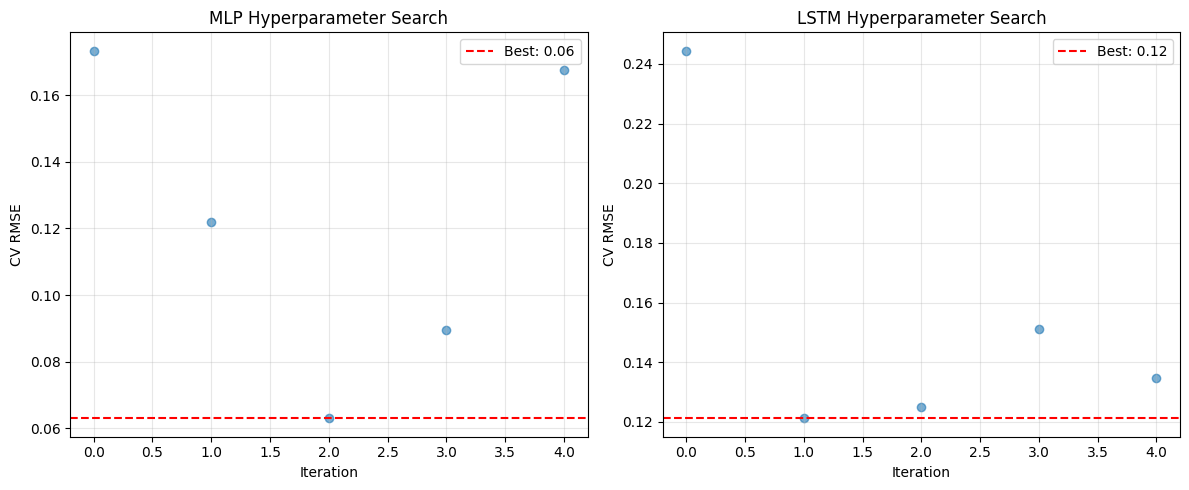

In [65]:
# Plot hyperparameter search results
plot_hyperparameter_search_results(
    training_results['mlp']['cv_results'],
    training_results['lstm']['cv_results']
)

In [66]:
def plot_training_history(
    mlp_history,
    lstm_history
):
    """Plot training history for both models"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(mlp_history.history['loss'], label='Train')
    ax1.plot(mlp_history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('MLP Training History')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(lstm_history.history['loss'], label='Train')
    ax2.plot(lstm_history.history['val_loss'], label='Validation')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('LSTM Training History')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        'storm_nn_training_history.png',
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()

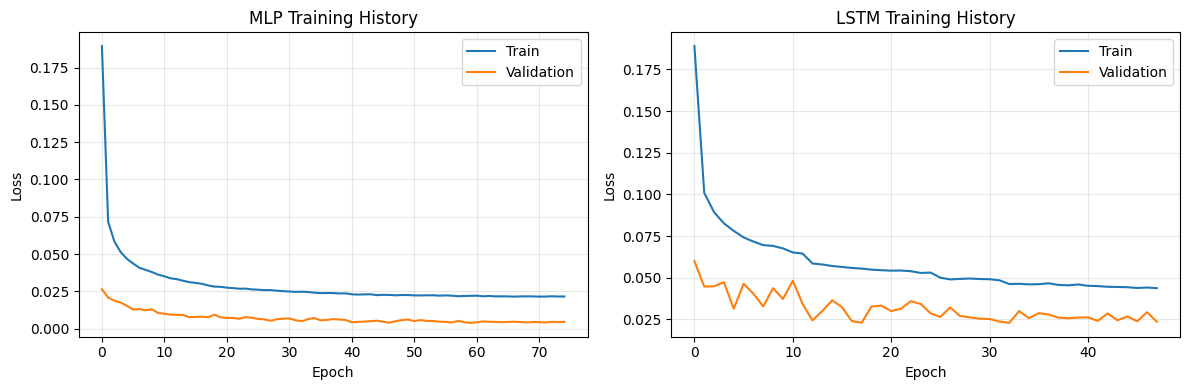

In [67]:
# Plot training history
plot_training_history(mlp_history, lstm_history)

In [68]:
def plot_sample_predictions(
    test_sids,
    df_test,
    test_storm_ids,
    mlp_results,
    lstm_results
):
    """Plot sample storm track predictions"""
    np.random.seed(42)
    selected_sids = np.random.choice(
        test_sids,
        min(3, len(test_sids)),
        replace=False
    )

    fig, axes = plt.subplots(
        1,
        len(selected_sids),
        figsize=(6*len(selected_sids), 5)
    )
    if len(selected_sids) == 1:
        axes = [axes]

    for idx, sid in enumerate(selected_sids):
        ax = axes[idx]

        # Get storm data
        storm_data = df_test[df_test['SID'] == sid].sort_values('ISO_TIME')
        full_track = storm_data[['x', 'y']].values

        # Get predictions for this storm
        storm_mask = np.array(test_storm_ids) == sid
        storm_indices = np.where(storm_mask)[0]

        if len(storm_indices) > 0:
            mlp_preds = mlp_results['predictions_deg'][storm_indices]
            lstm_preds = lstm_results['predictions_deg'][storm_indices]

            # Plot tracks
            ax.plot(
                full_track[:, 0],
                full_track[:, 1],
                'k-',
                linewidth=2,
                label='Actual'
            )
            ax.plot(
                full_track[:WINDOW_SIZE, 0],
                full_track[:WINDOW_SIZE, 1],
                'k-',
                linewidth=4,
                alpha=0.6
            )

            # Plot predictions
            pred_track_start = full_track[WINDOW_SIZE-1:WINDOW_SIZE+len(mlp_preds)-1]
            for i in range(len(mlp_preds)):
                if i < len(pred_track_start):
                    ax.plot(
                        [pred_track_start[i, 0], mlp_preds[i, 0]],
                        [pred_track_start[i, 1], mlp_preds[i, 1]],
                        'b-',
                        alpha=0.5,
                        linewidth=1
                    )
                    ax.plot(
                        [pred_track_start[i, 0], lstm_preds[i, 0]],
                        [pred_track_start[i, 1], lstm_preds[i, 1]],
                        'r-',
                        alpha=0.5,
                        linewidth=1
                    )

            ax.scatter(
                mlp_preds[:, 0],
                mlp_preds[:, 1],
                c='blue',
                s=30,
                alpha=0.6,
                label='MLP'
            )
            ax.scatter(
                lstm_preds[:, 0],
                lstm_preds[:, 1],
                c='red',
                s=30,
                alpha=0.6,
                label='LSTM'
            )

            # Calculate mean errors
            mlp_mean = np.mean(mlp_results['errors_by_storm'][sid])
            lstm_mean = np.mean(lstm_results['errors_by_storm'][sid])

            ax.set_title(
                f'Storm {sid[-6:]}\n'
                f'MLP: {mlp_mean:.1f} km | LSTM: {lstm_mean:.1f} km'
            )
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal', adjustable='box')

    plt.suptitle('Sample Storm Track Predictions', fontsize=14)
    plt.tight_layout()
    plt.savefig(
        'storm_nn_sample_predictions.png',
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()

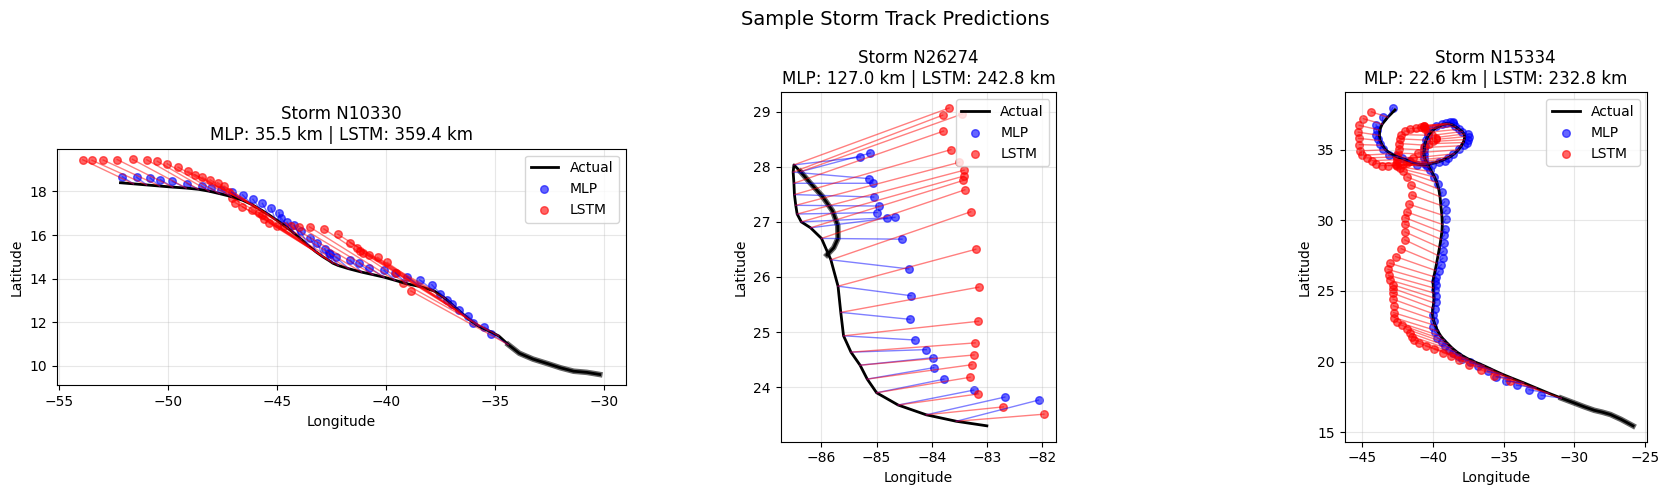

In [69]:
# Plot sample predictions
plot_sample_predictions(
    test_sids,
    df_test,
    test_storm_ids,
    mlp_results,
    lstm_results
)

In [70]:
def plot_performance_comparison(
    mlp_results,
    lstm_results,
    TEST_YEARS
):
    """Plot comprehensive performance comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Metric comparison
    ax = axes[0, 0]
    metrics_names = ['RMSE', 'MAE', 'Median', '90th %ile']
    mlp_values = [
        mlp_results['window_metrics']['rmse'],
        mlp_results['window_metrics']['mae'],
        mlp_results['window_metrics']['median'],
        mlp_results['window_metrics']['p90']
    ]
    lstm_values = [
        lstm_results['window_metrics']['rmse'],
        lstm_results['window_metrics']['mae'],
        lstm_results['window_metrics']['median'],
        lstm_results['window_metrics']['p90']
    ]

    x = np.arange(len(metrics_names))
    width = 0.35
    ax.bar(
        x - width/2,
        mlp_values,
        width,
        label='MLP',
        color='blue',
        alpha=0.8
    )
    ax.bar(
        x + width/2,
        lstm_values,
        width,
        label='LSTM',
        color='red',
        alpha=0.8
    )
    ax.set_xlabel('Metric')
    ax.set_ylabel('Error (km)')
    ax.set_title('Performance Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Error distributions
    ax = axes[0, 1]
    ax.hist(
        mlp_results['errors_km'],
        bins=50,
        alpha=0.5,
        label='MLP',
        color='blue',
        density=True
    )
    ax.hist(
        lstm_results['errors_km'],
        bins=50,
        alpha=0.5,
        label='LSTM',
        color='red',
        density=True
    )
    ax.set_xlabel('Error (km)')
    ax.set_ylabel('Density')
    ax.set_title('Error Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Cumulative distribution
    ax = axes[1, 0]
    mlp_sorted = np.sort(mlp_results['errors_km'])
    lstm_sorted = np.sort(lstm_results['errors_km'])
    mlp_cdf = np.arange(1, len(mlp_sorted) + 1) / len(mlp_sorted)
    lstm_cdf = np.arange(1, len(lstm_sorted) + 1) / len(lstm_sorted)
    ax.plot(mlp_sorted, mlp_cdf, 'b-', label='MLP', linewidth=2)
    ax.plot(lstm_sorted, lstm_cdf, 'r-', label='LSTM', linewidth=2)
    ax.set_xlabel('Error (km)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title('Cumulative Error Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Summary statistics
    ax = axes[1, 1]
    ax.axis('off')

    summary_text = f"""Performance Summary (Test Years {TEST_YEARS[0]}-{TEST_YEARS[1]}):

                  MLP        LSTM       Better
==============================================
RMSE (km):     {mlp_results['window_metrics']['rmse']:7.2f}    {lstm_results['window_metrics']['rmse']:7.2f}    {'MLP' if mlp_results['window_metrics']['rmse'] < lstm_results['window_metrics']['rmse'] else 'LSTM'}
MAE (km):      {mlp_results['window_metrics']['mae']:7.2f}    {lstm_results['window_metrics']['mae']:7.2f}    {'MLP' if mlp_results['window_metrics']['mae'] < lstm_results['window_metrics']['mae'] else 'LSTM'}
Median (km):   {mlp_results['window_metrics']['median']:7.2f}    {lstm_results['window_metrics']['median']:7.2f}    {'MLP' if mlp_results['window_metrics']['median'] < lstm_results['window_metrics']['median'] else 'LSTM'}
90th % (km):   {mlp_results['window_metrics']['p90']:7.2f}    {lstm_results['window_metrics']['p90']:7.2f}    {'MLP' if mlp_results['window_metrics']['p90'] < lstm_results['window_metrics']['p90'] else 'LSTM'}

Storm RMSE:    {mlp_results['storm_metrics']['storm_rmse']:7.2f}    {lstm_results['storm_metrics']['storm_rmse']:7.2f}    {'MLP' if mlp_results['storm_metrics']['storm_rmse'] < lstm_results['storm_metrics']['storm_rmse'] else 'LSTM'}
Storm MAE:     {mlp_results['storm_metrics']['storm_mae']:7.2f}    {lstm_results['storm_metrics']['storm_mae']:7.2f}    {'MLP' if mlp_results['storm_metrics']['storm_mae'] < lstm_results['storm_metrics']['storm_mae'] else 'LSTM'}

Test Storms: {mlp_results['storm_metrics']['n_storms']}
Test Samples: {len(mlp_results['errors_km'])}"""

    ax.text(
        0.1,
        0.5,
        summary_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='center',
        fontfamily='monospace'
    )

    plt.suptitle('Neural Network Performance Comparison', fontsize=16)
    plt.tight_layout()
    plt.savefig(
        'storm_nn_performance_comparison.png',
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()

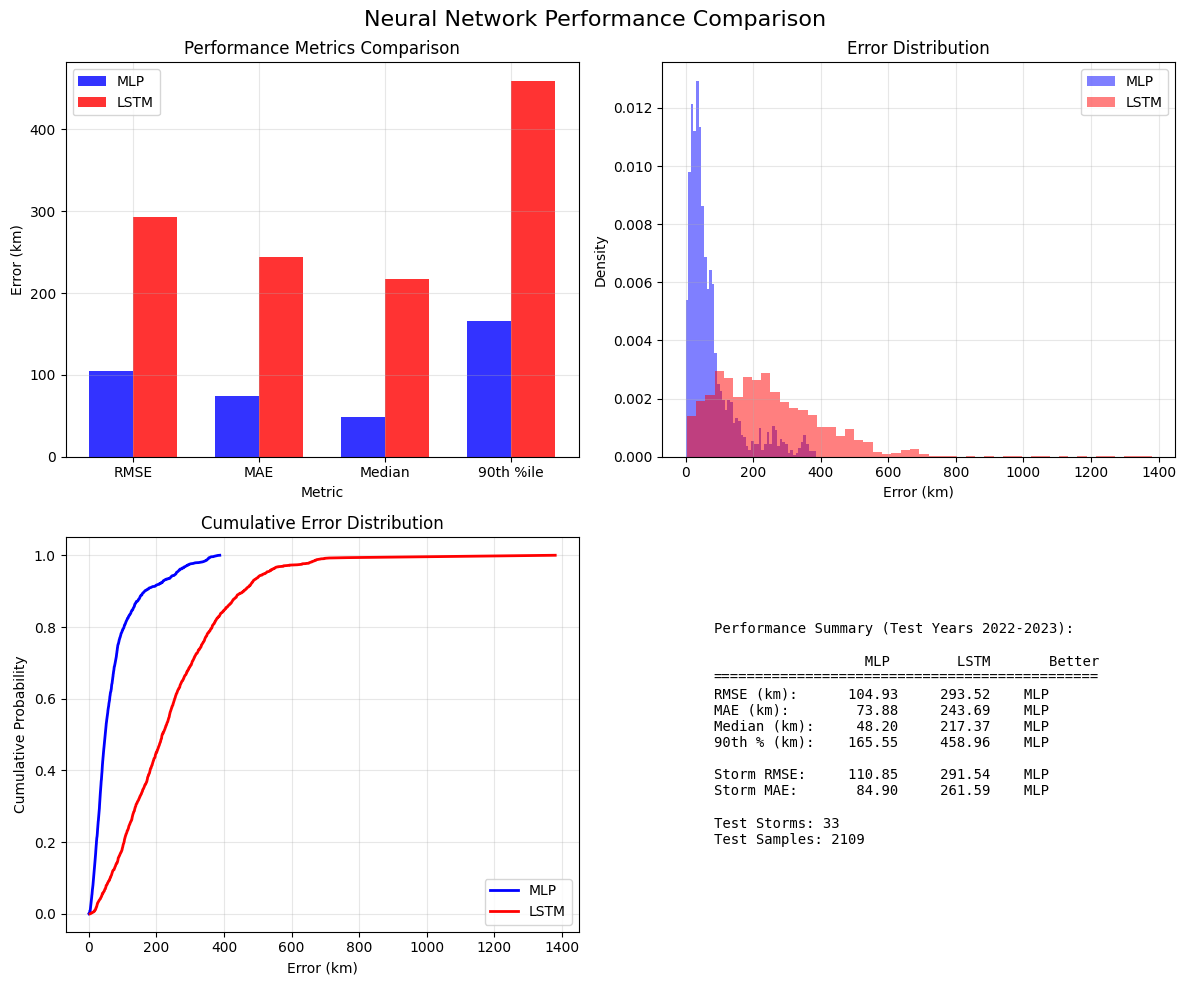

In [71]:
# Plot performance comparison
plot_performance_comparison(
    mlp_results,
    lstm_results,
    TEST_YEARS
)

In [72]:
def plot_best_parameters():
    """Plot best hyperparameters found"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # MLP parameters
    mlp_params_to_plot = {
        k: v for k, v in best_mlp_params.items()
        if k not in ['batch_size']
    }
    params = list(mlp_params_to_plot.keys())
    values = list(mlp_params_to_plot.values())

    ax1.barh(params, values, color='steelblue', alpha=0.8)
    ax1.set_xlabel('Value')
    ax1.set_title('Best MLP Hyperparameters')
    ax1.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(values):
        # Handle numpy types and format
        if isinstance(v, (float, np.floating)):
            text = f'{float(v):.4f}'
        else:
            text = str(v)

        # Text positioning
        offset = max(0.01, abs(v) * 0.05)
        ax1.text(v + offset, i, text, va='center')

    # LSTM parameters
    lstm_params_to_plot = {
        k: v for k, v in best_lstm_params.items()
        if k not in ['batch_size']
    }
    params = list(lstm_params_to_plot.keys())
    values = list(lstm_params_to_plot.values())

    ax2.barh(params, values, color='coral', alpha=0.8)
    ax2.set_xlabel('Value')
    ax2.set_title('Best LSTM Hyperparameters')
    ax2.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(values):
        # Handle numpy types and format
        if isinstance(v, (float, np.floating)):
            text = f'{float(v):.4f}'
        else:
            text = str(v)

        # Text positioning
        offset = max(0.01, abs(v) * 0.05)
        ax2.text(v + offset, i, text, va='center')

    plt.tight_layout()
    plt.savefig(
        'storm_nn_best_hyperparameters.png',
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()

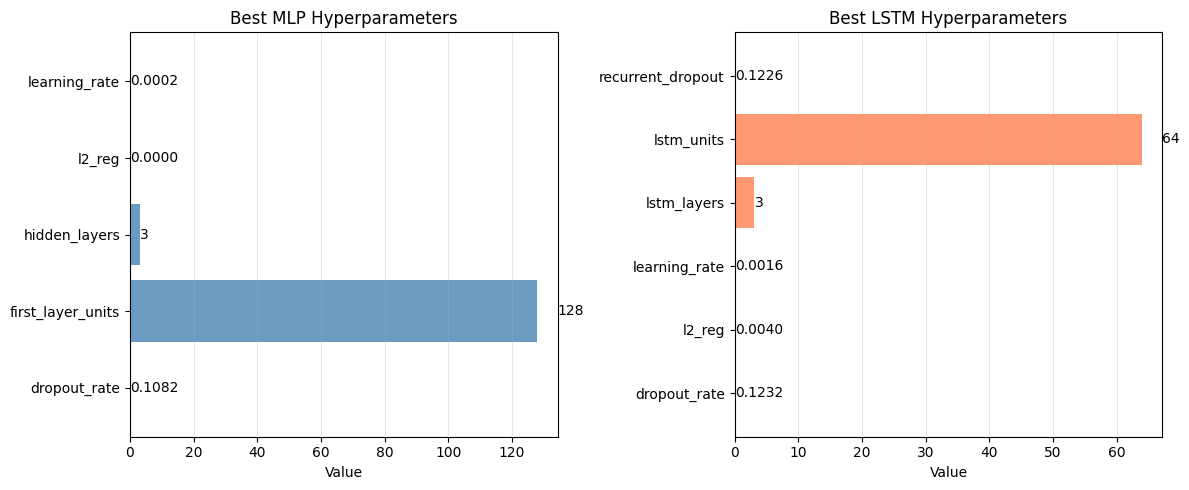

In [73]:
# Plot best hyperparameters
plot_best_parameters()

In [74]:
def plot_best_parameters():
    """Plot best hyperparameters found"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Define which parameters should use log scale
    log_scale_params = ['l2_reg', 'learning_rate']

    # MLP parameters
    mlp_params_to_plot = {
        k: v for k, v in best_mlp_params.items()
        if k not in ['batch_size']
    }
    params = list(mlp_params_to_plot.keys())
    values = list(mlp_params_to_plot.values())

    # Check if we need log scale for MLP
    needs_log = any(p in log_scale_params for p in params)

    ax1.barh(params, values, color='steelblue', alpha=0.8)
    ax1.set_xlabel('Value (Log Scale)' if needs_log else 'Value')
    ax1.set_title('Best MLP Hyperparameters')
    if needs_log:
        ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (param, v) in enumerate(zip(params, values)):
        # Handle numpy types and format
        if isinstance(v, (float, np.floating)):
            if param in log_scale_params:
                text = f'{float(v):.2e}'  # Scientific notation for tiny values
            else:
                text = f'{float(v):.4f}'
        else:
            text = str(v)

        # Text positioning - adjust for log scale
        if needs_log and param in log_scale_params:
            # For log scale, position text to the right of bar
            offset = v * 1.5
        else:
            # For linear scale, use original logic
            offset = max(0.01, abs(v) * 0.05)
        ax1.text(v + offset, i, text, va='center')

    # LSTM parameters
    lstm_params_to_plot = {
        k: v for k, v in best_lstm_params.items()
        if k not in ['batch_size']
    }
    params = list(lstm_params_to_plot.keys())
    values = list(lstm_params_to_plot.values())

    # Check if we need log scale for LSTM
    needs_log = any(p in log_scale_params for p in params)

    ax2.barh(params, values, color='coral', alpha=0.8)
    ax2.set_xlabel('Value (Log Scale)' if needs_log else 'Value')
    ax2.set_title('Best LSTM Hyperparameters')
    if needs_log:
        ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (param, v) in enumerate(zip(params, values)):
        # Handle numpy types and format
        if isinstance(v, (float, np.floating)):
            if param in log_scale_params:
                text = f'{float(v):.2e}'  # Scientific notation for tiny values
            else:
                text = f'{float(v):.4f}'
        else:
            text = str(v)

        # Text positioning - adjust for log scale
        if needs_log and param in log_scale_params:
            # For log scale, position text to the right of bar
            offset = v * 1.5
        else:
            # For linear scale, use original logic
            offset = max(0.01, abs(v) * 0.05)
        ax2.text(v + offset, i, text, va='center')

    plt.tight_layout()
    plt.savefig(
        'storm_nn_best_hyperparameters.png',
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()

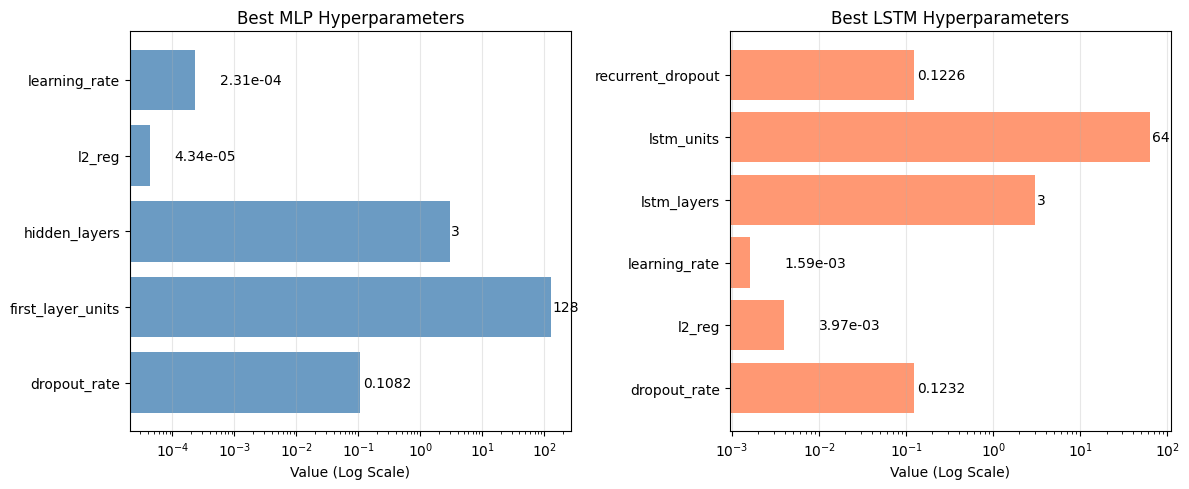

In [75]:
# Plot best hyperparameters
plot_best_parameters()

In [76]:
# Determine best model
if mlp_results['window_metrics']['rmse'] < lstm_results['window_metrics']['rmse']:
    best_model = 'mlp'
    best_model_obj = final_mlp_model
    print(f"Best model selected: MLP (RMSE: {mlp_results['window_metrics']['rmse']:.2f} km)")
else:
    best_model = 'lstm'
    best_model_obj = final_lstm_model
    print(f"Best model selected: LSTM (RMSE: {lstm_results['window_metrics']['rmse']:.2f} km)")

Best model selected: MLP (RMSE: 104.93 km)


# Results Saving

In [77]:
# Save production model
production_model_path = f'storm_{best_model}_production_model.h5'
best_model_obj.save(production_model_path)
print(f"Production model saved to: {production_model_path}")

Production model saved to: storm_mlp_production_model.h5


In [78]:
# Generate feature names
feature_names = [
    'x_km',
    'y_km',
    'vx',
    'vy',
    'ax',
    'ay',
    'curvature',
    'hour_sin',
    'hour_cos',
    'doy_sin',
    'doy_cos',
    'month_sin',
    'month_cos',
    'coriolis',
    'age_hours',
    'age_days',
    'lifecycle_pos',
    'lifecycle_sq',
    'lifecycle_cub'
]

In [79]:
# Save scalers and configuration
production_config = {
    'model_type': best_model,
    'test_years': TEST_YEARS,
    'window_size': WINDOW_SIZE,
    'horizon': HORIZON,
    'input_features': INPUT_FEATURES,
    'output_features': OUTPUT_FEATURES,
    'input_scaler': input_scaler,
    'output_scaler': output_scaler,
    'hyperparameters': best_mlp_params if best_model == 'mlp' else best_lstm_params,
    'performance': {
        'rmse': evaluation_results[best_model]['window_metrics']['rmse'],
        'mae': evaluation_results[best_model]['window_metrics']['mae'],
        'p90': evaluation_results[best_model]['window_metrics']['p90']
    },
    'feature_names': feature_names,
    'cv_folds': K_FOLDS,
    'random_search_iterations': N_ITER_SEARCH
}

joblib.dump(
    production_config,
    'storm_nn_production_config.pkl'
)
print("Production configuration saved to: storm_nn_production_config.pkl")

Production configuration saved to: storm_nn_production_config.pkl


In [80]:
# Save model comparison results
comparison_summary = pd.DataFrame([
    {
        'model': 'MLP',
        'rmse_km': mlp_results['window_metrics']['rmse'],
        'mae_km': mlp_results['window_metrics']['mae'],
        'median_km': mlp_results['window_metrics']['median'],
        'p90_km': mlp_results['window_metrics']['p90'],
        'storm_rmse_km': mlp_results['storm_metrics']['storm_rmse'],
        'best_params': str(best_mlp_params)
    },
    {
        'model': 'LSTM',
        'rmse_km': lstm_results['window_metrics']['rmse'],
        'mae_km': lstm_results['window_metrics']['mae'],
        'median_km': lstm_results['window_metrics']['median'],
        'p90_km': lstm_results['window_metrics']['p90'],
        'storm_rmse_km': lstm_results['storm_metrics']['storm_rmse'],
        'best_params': str(best_lstm_params)
    }
])

comparison_summary.to_csv(
    'storm_nn_comparison_summary.csv',
    index=False
)
print("Comparison summary saved to: storm_nn_comparison_summary.csv")

Comparison summary saved to: storm_nn_comparison_summary.csv


In [81]:
# Save all results
all_results = {
    'evaluation_results': evaluation_results,
    'training_results': training_results,
    'test_years': TEST_YEARS,
    'best_model': best_model,
    'input_features': INPUT_FEATURES,
    'feature_names': feature_names,
    'cv_results': {
        'mlp': mlp_random_search.cv_results_,
        'lstm': lstm_random_search.cv_results_
    }
}

joblib.dump(
    all_results,
    'storm_nn_all_results.pkl'
)
print("All results saved to: storm_nn_all_results.pkl")

All results saved to: storm_nn_all_results.pkl


In [82]:
print(f"Best model: {best_model.upper()}")
print(f"Production model ready for deployment: {production_model_path}")
print(f"Total features used: {INPUT_FEATURES}")
print(f"Test years: {TEST_YEARS[0]}-{TEST_YEARS[1]}")
print(f"Hyperparameter tuning: {N_ITER_SEARCH} iterations with {K_FOLDS}-fold CV")

Best model: MLP
Production model ready for deployment: storm_mlp_production_model.h5
Total features used: 19
Test years: 2022-2023
Hyperparameter tuning: 5 iterations with 5-fold CV
